# AGP data
Data from the US and UK populations of the American Gut Project. 

See McDonald et al. 2018 - https://doi.org/10.1128/mSystems.00031-18

## US data 

## Libraries

In [1]:
library(cowplot)
library(ggplot2)
library(tidyverse)
library(knitr)
library(broom)
library(caret)
library(lspline)
library(scales)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



## Load data

In [2]:
US_data = read.table(file = "./data/AmericanGutUSA1250.txt", header=TRUE, sep='\t', comment.char='', check.names=FALSE,
                     colClasses = c("character","character","character","factor","integer","character","character","numeric","numeric","numeric","factor"))

In [3]:
US_data

#SampleID,BarcodeSequence,LinkerPrimerSequence,sex,Age,country,Healthy,observed_otus_1250,faiths_pd_1250,shannon_1250,Description
10317.000049761,TCCGGACTCCTG,GTGYCAGCMGCCGCGGTAA,male,53,USA,True,140.3,17.388163,4.794003,Old
10317.000028857,CCAGTATCGCGT,GTGCCAGCMGCCGCGGTAA,female,57,USA,Yes,133.7,14.960665,5.194171,Old
10317.000062081,AGCCTGGTACCT,GTGYCAGCMGCCGCGGTAA,male,21,USA,True,90.6,10.635987,4.804864,Young
10317.000023295,TATCCAAGCGCA,GTGYCAGCMGCCGCGGTAA,male,56,USA,Yes,152.6,15.578103,6.110560,Old
10317.000030991,AGCTCTAGAAAC,GTGYCAGCMGCCGCGGTAA,male,63,USA,Yes,79.7,9.649967,4.308422,Old
10317.000021163,GGACCTGGATGG,GTGYCAGCMGCCGCGGTAA,male,55,USA,Yes,134.1,15.445436,5.405599,Old
10317.000031342,GTTGTTCTGGGA,GTGYCAGCMGCCGCGGTAA,male,55,USA,Yes,182.8,19.635219,6.150405,Old
10317.000054319,CTCACGCAATGC,GTGYCAGCMGCCGCGGTAA,male,41,USA,True,113.6,14.145781,5.267181,Young
10317.000009158,CCTTCTGTATAC,GTGCCAGCMGCCGCGGTAA,female,60,USA,Yes,179.5,20.276188,6.036177,Old
10317.000041995,GTGGCGCATGGA,GTGYCAGCMGCCGCGGTAA,male,22,USA,Yes,75.7,9.249227,4.611883,Young


In [4]:
subset(US_data, sex == "female" & Description =='Young') %>% summary

  #SampleID         BarcodeSequence    LinkerPrimerSequence     sex     
 Length:627         Length:627         Length:627           female:627  
 Class :character   Class :character   Class :character     male  :  0  
 Mode  :character   Mode  :character   Mode  :character                 
                                                                        
                                                                        
                                                                        
      Age         country            Healthy          observed_otus_1250
 Min.   :20.0   Length:627         Length:627         Min.   : 27.70    
 1st Qu.:29.0   Class :character   Class :character   1st Qu.: 90.35    
 Median :35.0   Mode  :character   Mode  :character   Median :112.70    
 Mean   :34.6                                         Mean   :113.81    
 3rd Qu.:41.0                                         3rd Qu.:133.90    
 Max.   :45.0                                      

In [5]:
subset(US_data, sex == "female" & Description =='Young')$Age %>% sd
subset(US_data, sex == "female" & Description =='Young')$observed_otus_1250 %>% sd
subset(US_data, sex == "female" & Description =='Young')$shannon_1250 %>% sd

[1] 6.79364

[1] 33.03988

[1] 0.8290106

## Compare linear model and spline regression of alpha-diversity and age

In [6]:
# SV Richness
rich_null = lm(observed_otus_1250~1, data = US_data)
rich_lm = lm(observed_otus_1250~Age, data = US_data)
rich_ls = lm(observed_otus_1250~lspline(Age, c(45)), data = US_data)

AIC_rich = c(fit0 = AIC(rich_null), fit1 = AIC(rich_lm), fit2 = AIC(rich_ls)) %>%
    print

summary(rich_ls)

# Shannon
shannon_null = lm(shannon_1250~1, data = US_data)
shannon_lm = lm(shannon_1250~Age, data = US_data)
shannon_ls = lm(shannon_1250~lspline(Age, c(45)), data = US_data)

AIC_shannon = c(fit0 = AIC(shannon_null), fit1 = AIC(shannon_lm), fit2 = AIC(shannon_ls)) %>%
    print

    fit0     fit1     fit2 
25505.27 25462.05 25447.47 



Call:
lm(formula = observed_otus_1250 ~ lspline(Age, c(45)), data = US_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-101.279  -23.084   -0.133   22.011  116.005 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          86.50922    4.16075  20.792  < 2e-16 ***
lspline(Age, c(45))1  0.74856    0.11234   6.663 3.26e-11 ***
lspline(Age, c(45))2 -0.05721    0.10924  -0.524    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33 on 2585 degrees of freedom
Multiple R-squared:  0.02359,	Adjusted R-squared:  0.02284 
F-statistic: 31.23 on 2 and 2585 DF,  p-value: 3.955e-14


    fit0     fit1     fit2 
6401.352 6383.376 6377.846 


In [7]:
US_data$Description = factor(US_data$Description, levels=c("Young","Old"))
labels = c(Young = "20 - 45", Old = "46-69")

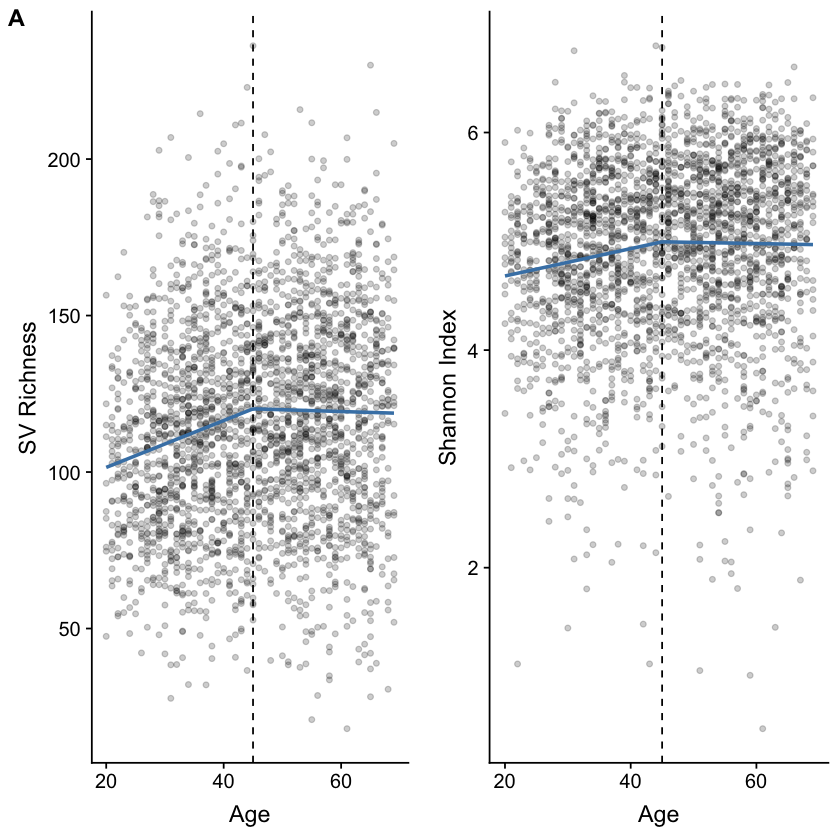

In [8]:
US_richness_spline = ggplot(US_data, aes(x = Age, y = observed_otus_1250)) +
    geom_point(size = 1.3, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
    
US_shannon_spline = ggplot(US_data,  aes(x = Age, y = shannon_1250)) +
    geom_point(size = 1.3, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
 

US_div_spline = plot_grid(US_richness_spline, US_shannon_spline, nrow = 1, labels = c("A", ""))
ggsave(filename = "./images/US_alpha_spline.png", 
       plot = US_div_spline, width = 7, height = 3,
       device = "png", dpi = "print")
plot(US_div_spline)

## Plots of alpha diversity, age and sex

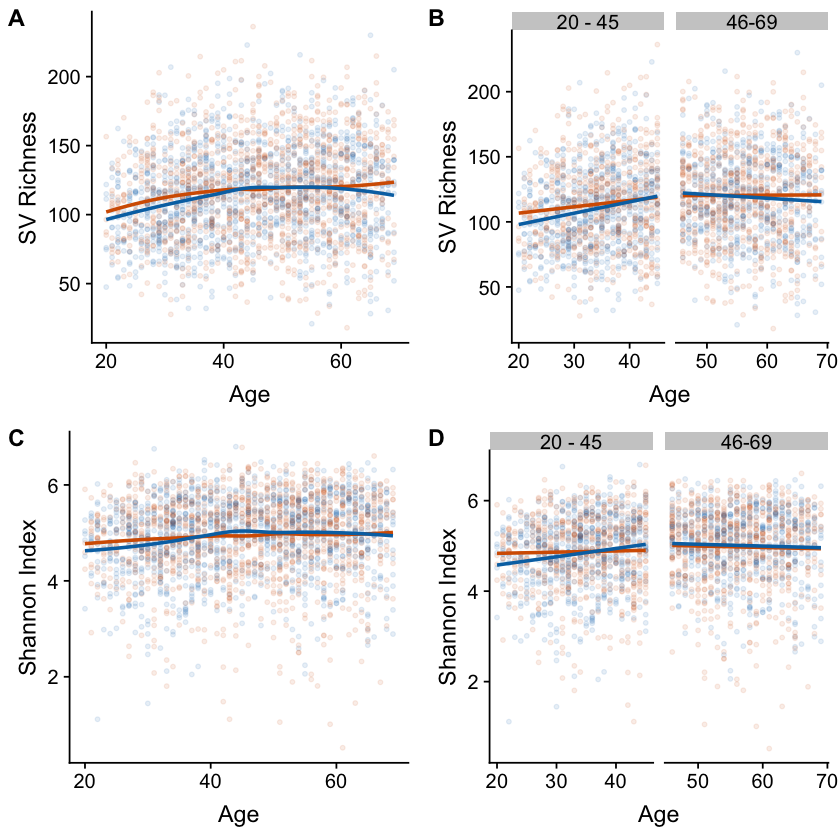

In [9]:
US_richness = ggplot(US_data, aes(x= Age, y = observed_otus_1250, color = sex)) + 
    geom_point(size = 1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "SV Richness") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

US_shannon = ggplot(US_data, aes(x = Age, y = shannon_1250, color = sex)) + 
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

US_richness_age_group = ggplot(US_data, aes(x = Age, y = observed_otus_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_shannon_age_group = ggplot(US_data, aes(x = Age, y = shannon_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~ Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_combine_plot = plot_grid(US_richness, US_richness_age_group, US_shannon, US_shannon_age_group, ncol = 2, labels = "AUTO")
US_combine_plot

In [10]:
# Manuscript plots
US_rich_gph = plot_grid(US_richness, US_richness_age_group, ncol = 2, labels = c("A", ""))
US_shannon_gph = plot_grid(US_shannon, US_shannon_age_group, ncol = 2, labels = c("A", ""))

ggsave(filename = "./images/US_rich_gph.png", 
       plot = US_rich_gph, width = 7, height = 3,
       device = "png", dpi = "print")
ggsave(filename = "./images/US_shannon_gph.png", plot = US_shannon_gph,
       width = 7, height = 3,
       device = "png", dpi = "print")

# Linear models

In [11]:
US_data %>% group_by(Description, sex) %>%
    summarise(V1=cor(observed_otus_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,0.100203931
Young,male,0.182498767
Old,female,0.004595506
Old,male,-0.055592254


In [12]:
US_data %>% group_by(Description, sex) %>%
    summarise(V1=cor(shannon_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,0.02179854
Young,male,0.15093761
Old,female,-0.02256112
Old,male,-0.03297588


In [13]:
# Empty data frame for p-values
pvals = data.frame(Population = character(), Metric = character(), Test = character(), pval = numeric())

In [14]:
US_otu_lm_young = lm(observed_otus_1250 ~ Age, data = US_data[which(US_data$Description == "Young"),])
summary(US_otu_lm_young)

sv_age_y = summary(US_otu_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_young", pval = sv_age_y))


Call:
lm(formula = observed_otus_1250 ~ Age, data = US_data[which(US_data$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-82.047 -22.677  -0.333  20.946 116.861 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  88.2241     4.6596  18.934  < 2e-16 ***
Age           0.6914     0.1338   5.168 2.74e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.99 on 1269 degrees of freedom
Multiple R-squared:  0.02061,	Adjusted R-squared:  0.01984 
F-statistic: 26.71 on 1 and 1269 DF,  p-value: 2.744e-07


In [15]:
US_otu_lm_old = lm(observed_otus_1250 ~ Age, data = US_data[which(US_data$Description == "Old"),])
summary(US_otu_lm_old)

sv_age_m = summary(US_otu_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_middle", pval = sv_age_m))


Call:
lm(formula = observed_otus_1250 ~ Age, data = US_data[which(US_data$Description == 
    "Old"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-101.222  -23.741   -0.141   23.587  111.266 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 126.6571     8.3172  15.228   <2e-16 ***
Age          -0.1219     0.1461  -0.834    0.404    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.95 on 1315 degrees of freedom
Multiple R-squared:  0.0005291,	Adjusted R-squared:  -0.0002309 
F-statistic: 0.6961 on 1 and 1315 DF,  p-value: 0.4042


In [16]:
US_shannon_lm_young = lm(shannon_1250 ~ Age, data = US_data[which(US_data$Description == "Young"),])
summary(US_shannon_lm_young)

sh_age_y = summary(US_shannon_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_young", pval = sh_age_y))


Call:
lm(formula = shannon_1250 ~ Age, data = US_data[which(US_data$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8287 -0.4622  0.0969  0.5673  1.9343 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.49022    0.11843  37.915  < 2e-16 ***
Age          0.01056    0.00340   3.105  0.00194 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8132 on 1269 degrees of freedom
Multiple R-squared:  0.007542,	Adjusted R-squared:  0.00676 
F-statistic: 9.644 on 1 and 1269 DF,  p-value: 0.001942


In [17]:
US_shannon_lm_old = lm(shannon_1250 ~ Age, data = US_data[which(US_data$Description == "Old"),])
summary(US_shannon_lm_old)

sh_age_m = summary(US_shannon_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_middle", pval = sh_age_m))


Call:
lm(formula = shannon_1250 ~ Age, data = US_data[which(US_data$Description == 
    "Old"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4562 -0.4462  0.1445  0.6181  1.6430 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.179722   0.206702  25.059   <2e-16 ***
Age         -0.003334   0.003631  -0.918    0.359    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8437 on 1315 degrees of freedom
Multiple R-squared:  0.0006408,	Adjusted R-squared:  -0.0001191 
F-statistic: 0.8432 on 1 and 1315 DF,  p-value: 0.3586


### **ANCOVA of alpha-diversity and sex**

In [18]:
# OTU richness
# With interaction
US_otu_ancova = lm(observed_otus_1250 ~ sex * Age, data = US_data)
summary(US_otu_ancova)
anova(US_otu_ancova)


Call:
lm(formula = observed_otus_1250 ~ sex * Age, data = US_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-103.673  -23.474   -0.455   22.423  119.188 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 103.90108    3.41420  30.432  < 2e-16 ***
sexmale      -6.46849    4.75423  -1.361    0.174    
Age           0.29134    0.07129   4.087  4.5e-05 ***
sexmale:Age   0.08305    0.10038   0.827    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.08 on 2584 degrees of freedom
Multiple R-squared:  0.01919,	Adjusted R-squared:  0.01805 
F-statistic: 16.85 on 3 and 2584 DF,  p-value: 7.673e-11


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,6341.7188,6341.7188,5.7947632,1.614369e-02
Age,1,48242.4450,48242.4450,44.0816688,3.824900e-11
sex:Age,1,749.1334,749.1334,0.6845228,4.081101e-01
Residuals,2584,2827898.3340,1094.3879,NA,NA


In [19]:
# OTU
# Without interaction
US_otu_anova = lm(observed_otus_1250 ~ sex + Age, data = US_data)
summary(US_otu_anova)
anova(US_otu_anova)


Call:
lm(formula = observed_otus_1250 ~ sex + Age, data = US_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-104.292  -23.544   -0.369   22.495  119.239 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 101.96550    2.48654   41.01  < 2e-16 ***
sexmale      -2.68591    1.30399   -2.06   0.0395 *  
Age           0.33323    0.05019    6.64 3.81e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.08 on 2585 degrees of freedom
Multiple R-squared:  0.01893,	Adjusted R-squared:  0.01817 
F-statistic: 24.94 on 2 and 2585 DF,  p-value: 1.868e-11


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,6341.719,6341.719,5.795471,1.613718e-02
Age,1,48242.445,48242.445,44.087049,3.814293e-11
Residuals,2585,2828647.467,1094.254,NA,NA


In [20]:
# Shannon
# With interaction
US_shannon_ancova = lm(shannon_1250 ~ sex * Age, data = US_data)
summary(US_shannon_ancova)
anova(US_shannon_ancova)


Call:
lm(formula = shannon_1250 ~ sex * Age, data = US_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4606 -0.4713  0.1192  0.5894  1.9455 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.771514   0.085634  55.720   <2e-16 ***
sexmale     -0.205603   0.119244  -1.724   0.0848 .  
Age          0.003430   0.001788   1.919   0.0552 .  
sexmale:Age  0.004325   0.002518   1.718   0.0860 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8297 on 2584 degrees of freedom
Multiple R-squared:  0.008848,	Adjusted R-squared:  0.007697 
F-statistic: 7.689 on 3 and 2584 DF,  p-value: 4.1e-05


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,0.1692492,0.1692492,0.245835,6.200653e-01
Age,1,13.6796383,13.6796383,19.869717,8.643890e-06
sex:Age,1,2.0313259,2.0313259,2.950507,8.597042e-02
Residuals,2584,1778.9979067,0.6884667,NA,NA


In [21]:
# Shannon
# Without interaction
US_shannon_anova = lm(shannon_1250 ~ sex + Age, data = US_data)
summary(US_shannon_anova)
anova(US_shannon_anova)


Call:
lm(formula = shannon_1250 ~ sex + Age, data = US_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4929 -0.4590  0.1155  0.5838  1.9158 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.670723   0.062394  74.859  < 2e-16 ***
sexmale     -0.008633   0.032721  -0.264    0.792    
Age          0.005611   0.001259   4.456 8.71e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8301 on 2585 degrees of freedom
Multiple R-squared:  0.007716,	Adjusted R-squared:  0.006948 
F-statistic: 10.05 on 2 and 2585 DF,  p-value: 4.489e-05


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,0.1692492,0.1692492,0.2456497,6.201972e-01
Age,1,13.6796383,13.6796383,19.8547359,8.711235e-06
Residuals,2585,1781.0292326,0.6889862,NA,NA


### **Fit separate linear models by each age group**

In [22]:
# OTU richness
# Without interaction
US_otu_group_lm = US_data %>% group_by(Description) %>%
    do (otu_lm = lm (observed_otus_1250 ~ sex + Age, data=.))

US_otu_group_coef = tidy(US_otu_group_lm, otu_lm)
US_otu_group_coef

US_otu_group_R2 = glance(US_otu_group_lm, otu_lm)
US_otu_group_R2

sv_age_sex_y = US_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_sex_young", pval = sv_age_sex_y))

sv_age_sex_m = US_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_sex_middle", pval = sv_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),90.4227442,4.8068808,18.8111060,8.113230e-70
Young,sexmale,-3.2985760,1.7969158,-1.8356876,6.663793e-02
Young,Age,0.6760066,0.1339275,5.0475581,5.127302e-07
Old,(Intercept),126.7920123,8.3210846,15.2374382,2.117478e-48
Old,sexmale,-1.3224544,1.8894660,-0.6999091,4.841080e-01
Old,Age,-0.1139236,0.1465569,-0.7773335,4.371019e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.0232097155,0.0216690368,31.96500,15.0646048,3.420141e-07,3,-6205.529,12419.06,12439.65,1295594,1268
Old,0.0009015812,-0.0006191165,33.95593,0.5928734,5.528846e-01,3,-6509.749,13027.50,13048.23,1515049,1314


In [23]:
# OTU
# With interaction
US_otu_group_anc = US_data %>% group_by(Description) %>%
    do (otu_anc = lm (observed_otus_1250 ~ sex * Age, data=.))

US_otu_anc_group_coef = tidy(US_otu_group_anc, otu_anc)
US_otu_anc_group_coef

US_otu_anc_group_R2 = glance(US_otu_group_anc, otu_anc)
US_otu_anc_group_R2

sv_age_sex_inter_y = US_otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_sex_interaction_young", pval = sv_age_sex_inter_y))

sv_age_sex_inter_m = US_otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Richness", Test = "age_sex_interaction_middle", pval = sv_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),96.95159287,6.6285494,14.6263664,6.979799e-45
Young,sexmale,-16.38322798,9.3259451,-1.7567365,7.920428e-02
Young,Age,0.48732722,0.1879777,2.5924736,9.638520e-03
Young,sexmale:Age,0.38286288,0.2677723,1.4298074,1.530188e-01
Old,(Intercept),118.99569726,11.1172840,10.7036662,1.083133e-25
Old,sexmale,16.35125908,16.8203312,0.9721128,3.311735e-01
Old,Age,0.02497532,0.1968026,0.1269055,8.990347e-01
Old,sexmale:Age,-0.31179117,0.2948582,-1.0574273,2.905111e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.024783262,0.0224741459,31.95185,10.732791,5.742901e-07,4,-6204.504,12419.01,12444.75,1293506,1267
Old,0.001751691,-0.0005291507,33.95441,0.768002,5.119726e-01,4,-6509.189,13028.38,13054.29,1513760,1313


In [24]:
#Shannon
# Without interaction
US_shannon_group_lm = US_data %>% group_by(Description) %>%
    do (shannon_lm = lm (shannon_1250 ~ sex + Age, data=.))

US_shannon_group_coef = tidy(US_shannon_group_lm, shannon_lm)
US_shannon_group_coef

US_shannon_group_R2 = glance(US_shannon_group_lm, shannon_lm)
US_shannon_group_R2

sh_age_sex_y = US_shannon_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_sex_young", pval = sh_age_sex_y))

sh_age_sex_m = US_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_sex_middle", pval = sh_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.514533948,0.122302466,36.9128611,3.630239e-203
Young,sexmale,-0.036478689,0.045719301,-0.7978838,4.250873e-01
Young,Age,0.010389088,0.003407544,3.0488493,2.344783e-03
Old,(Intercept),5.176311574,0.206795784,25.0310305,2.175332e-113
Old,sexmale,0.033436587,0.046957051,0.7120674,4.765494e-01
Old,Age,-0.003535248,0.003642235,-0.9706262,3.319131e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.008040428,0.006475823,0.8132922,5.1389507,0.005986578,3,-1539.298,3086.596,3107.187,838.7113,1268
Old,0.001026323,-0.000494185,0.8438736,0.6749869,0.509339561,3,-1643.676,3295.352,3316.085,935.7292,1314


In [25]:
# Shannon
# With interaction
US_shannon_group_anc = US_data %>% group_by(Description) %>%
    do (shannon_anc = lm (shannon_1250 ~ sex * Age, data=.))

US_shannon_anc_group_coef = tidy(US_shannon_group_anc, shannon_anc)
US_shannon_anc_group_coef

US_shannon_anc_group_R2 = glance(US_shannon_group_anc, shannon_anc)
US_shannon_anc_group_R2

sh_age_sex_inter_y = US_shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_sex_interaction_young", pval = sh_age_sex_inter_y))

sh_age_sex_inter_m = US_shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "US", Metric = "Shannon", Test = "age_sex_interaction_middle", pval = sh_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.7819818857,0.168434787,28.3907023,1.242054e-137
Young,sexmale,-0.5724787327,0.236976972,-2.4157568,1.584327e-02
Young,Age,0.0026600202,0.004776608,0.5568847,5.777045e-01
Young,sexmale:Age,0.0156836055,0.006804230,2.3049786,2.132877e-02
Old,(Intercept),5.1553086449,0.276403232,18.6514051,4.683232e-69
Old,sexmale,0.0810487932,0.418195119,0.1938062,8.463576e-01
Old,Age,-0.0031610609,0.004893000,-0.6460374,5.183680e-01
Old,sexmale:Age,-0.0008399517,0.007330907,-0.1145768,9.087981e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.012182654,0.009843702,0.8119126,5.2085955,0.001411211,4,-1536.639,3083.278,3109.016,835.2090,1267
Old,0.001036311,-0.001246165,0.8441907,0.4540292,0.714489400,4,-1643.670,3297.339,3323.255,935.7198,1313


## UK data 

In [26]:
UK_data = read.table(file = "./data/AmericanGutUK1250.txt", header=TRUE, sep='\t', comment.char='', check.names=FALSE,
                     colClasses = c("character","character","character","factor","integer","character","character","numeric","numeric","numeric","factor"))

In [27]:
UK_data

#SampleID,BarcodeSequence,LinkerPrimerSequence,sex,Age,country,Healthy,observed_otus_1250,faiths_pd_1250,shannon_1250,Description
10317.000030322,AATAGATGCTGA,GTGYCAGCMGCCGCGGTAA,male,43,United Kingdom,Yes,139.4,18.56266,4.403524,Young
10317.000038189,TATAATCCGAGG,GTGYCAGCMGCCGCGGTAA,male,40,United Kingdom,Yes,147.1,17.80212,5.883753,Young
10317.000030166,AGGACAAACTAT,GTGYCAGCMGCCGCGGTAA,female,58,United Kingdom,Yes,127.7,15.69468,5.148391,Old
10317.000059006,GTGCGAGGACAA,GTGYCAGCMGCCGCGGTAA,female,64,United Kingdom,True,164.5,18.94117,5.826680,Old
10317.000020516,TAAGACTACTGG,GTGCCAGCMGCCGCGGTAA,male,51,United Kingdom,Yes,133.4,15.70971,5.288770,Old
10317.000032631,AGACAAGCTTCC,GTGYCAGCMGCCGCGGTAA,male,42,United Kingdom,Yes,124.9,14.56598,5.716547,Young
10317.000030018,CGCGGCGCAGCT,GTGYCAGCMGCCGCGGTAA,male,43,United Kingdom,Yes,111.5,15.01601,4.684171,Young
10317.000066631,AGATTCGCTCGA,GTGYCAGCMGCCGCGGTAA,female,66,United Kingdom,True,163.2,17.29777,5.771485,Old
10317.000047200,GCCAAGGATAGG,GTGYCAGCMGCCGCGGTAA,female,46,United Kingdom,True,101.3,12.45612,3.971698,Old
10317.000030377,CTTCCAACTCAT,GTGYCAGCMGCCGCGGTAA,male,68,United Kingdom,Yes,111.1,11.59387,5.216564,Old


In [28]:
subset(UK_data, sex == "male" & Description =='Young') %>% summary

  #SampleID         BarcodeSequence    LinkerPrimerSequence     sex     
 Length:173         Length:173         Length:173           female:  0  
 Class :character   Class :character   Class :character     male  :173  
 Mode  :character   Mode  :character   Mode  :character                 
                                                                        
                                                                        
                                                                        
      Age         country            Healthy          observed_otus_1250
 Min.   :20.0   Length:173         Length:173         Min.   : 37.3     
 1st Qu.:32.0   Class :character   Class :character   1st Qu.: 99.9     
 Median :38.0   Mode  :character   Mode  :character   Median :123.9     
 Mean   :36.4                                         Mean   :122.6     
 3rd Qu.:41.0                                         3rd Qu.:143.5     
 Max.   :45.0                                      

In [29]:
subset(UK_data, sex == "male" & Description =='Young')$Age %>% sd
subset(UK_data, sex == "male" & Description =='Young')$observed_otus_1250 %>% sd
subset(UK_data, sex == "male" & Description =='Young')$shannon_1250 %>% sd

[1] 6.318798

[1] 32.38219

[1] 0.915747

In [30]:
# SV Richness
UK_rich_null = lm(observed_otus_1250~1, data = UK_data)
UK_rich_lm = lm(observed_otus_1250~Age, data = UK_data)
UK_rich_ls = lm(observed_otus_1250~lspline(Age, c(45)), data = UK_data)

UK_AIC_rich = c(fit0 = AIC(UK_rich_null), fit1 = AIC(UK_rich_lm), fit2 = AIC(UK_rich_ls)) %>%
    print

summary(UK_rich_ls)

# Shannon
UK_shannon_null = lm(shannon_1250~1, data = UK_data)
UK_shannon_lm = lm(shannon_1250~Age, data = UK_data)
UK_shannon_ls = lm(shannon_1250~lspline(Age, c(45)), data = UK_data)

AIC_shannon = c(fit0 = AIC(UK_shannon_null), fit1 = AIC(UK_shannon_lm), fit2 = AIC(UK_shannon_ls)) %>%
    print

    fit0     fit1     fit2 
9334.114 9292.891 9292.336 



Call:
lm(formula = observed_otus_1250 ~ lspline(Age, c(45)), data = UK_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-103.500  -24.524   -1.066   23.357  106.940 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           92.9391     9.1471  10.160  < 2e-16 ***
lspline(Age, c(45))1   0.9635     0.2339   4.119 4.15e-05 ***
lspline(Age, c(45))2   0.3895     0.1724   2.259   0.0241 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.54 on 933 degrees of freedom
Multiple R-squared:  0.04773,	Adjusted R-squared:  0.04569 
F-statistic: 23.38 on 2 and 933 DF,  p-value: 1.234e-10


    fit0     fit1     fit2 
2288.688 2274.911 2274.735 


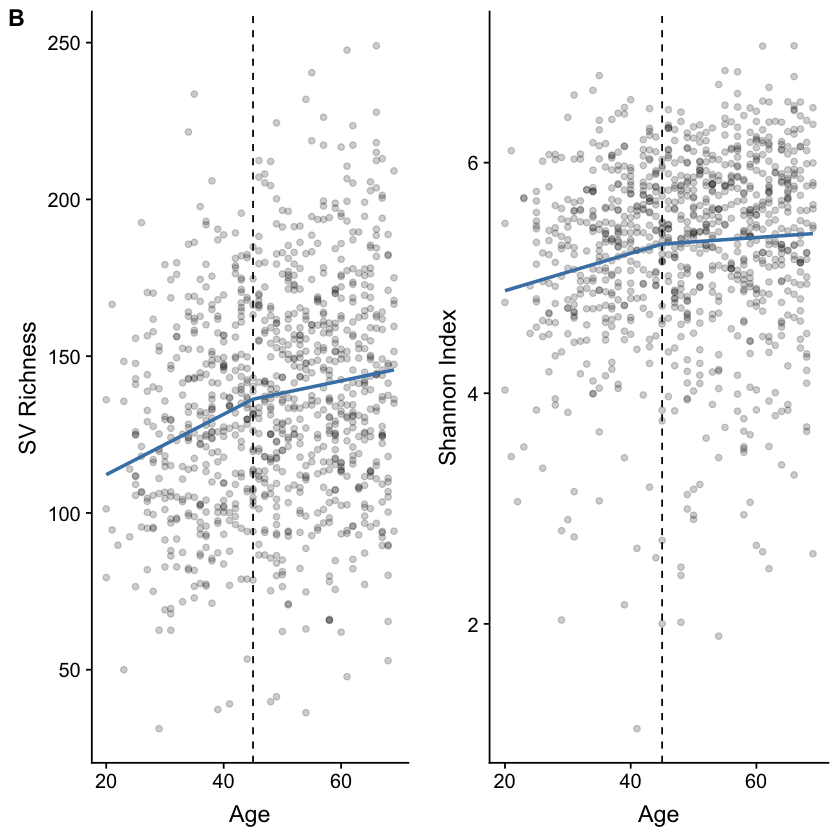

In [31]:
UK_richness_spline = ggplot(UK_data, aes(x = Age, y = observed_otus_1250)) +
    geom_point(size = 1.5, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
    
UK_shannon_spline = ggplot(UK_data,  aes(x = Age, y = shannon_1250)) +
    geom_point(size = 1.5, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
 

UK_div_spline = plot_grid(UK_richness_spline, UK_shannon_spline, nrow = 1, labels = c("B", ""))
ggsave(filename = "./images/UK_alpha_spline.png", 
       plot = UK_div_spline, width = 7, height = 3, 
       device = "png", dpi = "print")
plot(UK_div_spline)

In [32]:
UK_data$Description = factor(UK_data$Description, levels=c("Young","Old"))
labels = c(Young = "20 - 45", Old = "46-69")

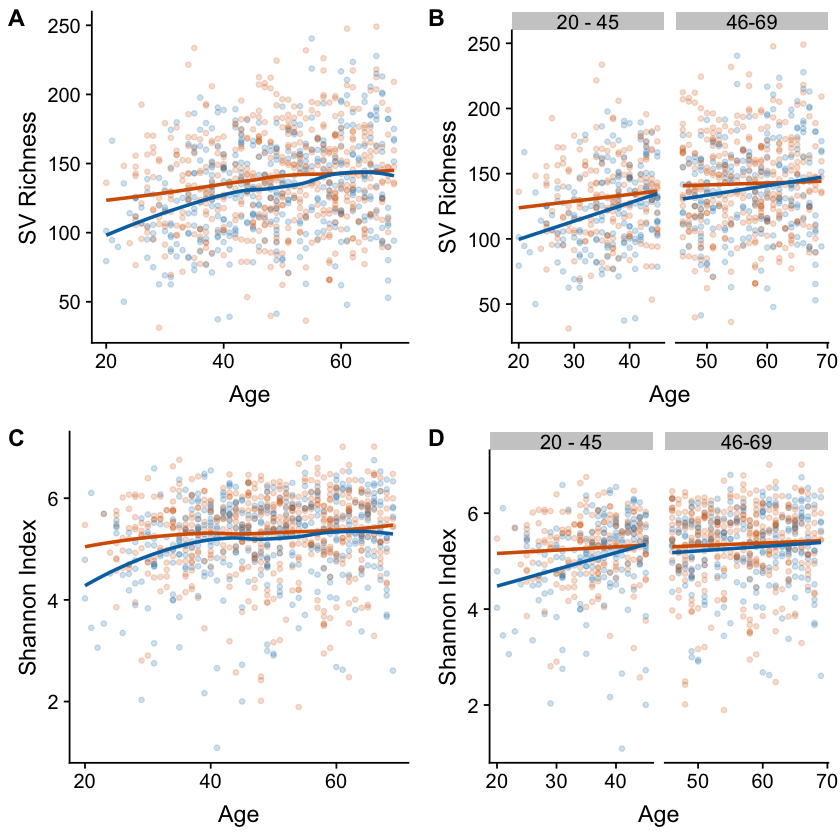

In [33]:
UK_richness = ggplot(UK_data, aes(x= Age, y = observed_otus_1250, color = sex)) + 
    geom_point(size = 1.2, alpha = 0.2) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "SV Richness") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

UK_shannon = ggplot(UK_data, aes(x = Age, y = shannon_1250, color = sex)) + 
    geom_point(size=1.2, alpha = 0.2) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

UK_richness_age_group = ggplot(UK_data, aes(x = Age, y = observed_otus_1250, color = sex)) +
    geom_point(size=1.2, alpha = 0.2) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

UK_shannon_age_group = ggplot(UK_data, aes(x = Age, y = shannon_1250, color = sex)) +
    geom_point(size=1.2, alpha = 0.2) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~ Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

UK_combine_plot = plot_grid(UK_richness, UK_richness_age_group, UK_shannon, UK_shannon_age_group, ncol = 2, labels = "AUTO")
UK_combine_plot


In [34]:
# Manuscript plots
UK_rich_gph = plot_grid(UK_richness, UK_richness_age_group, ncol = 2, labels = c("B", ""))
UK_shannon_gph = plot_grid(UK_shannon, UK_shannon_age_group, ncol = 2, labels = c("B", ""))

ggsave(filename = "./images/UK_rich_gph.png", plot = UK_rich_gph, 
       width = 7, height = 3, 
       device = "png", dpi = "print")

ggsave(filename = "./images/UK_shannon_gph.png", plot = UK_shannon_gph, 
       width = 7, height = 3,
       device = "png", dpi = "print")

In [35]:
UK_data %>% group_by(Description, sex) %>%
    summarise(V1=cor(observed_otus_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,0.09760222
Young,male,0.27371346
Old,female,0.02740288
Old,male,0.13723353


In [36]:
UK_data %>% group_by(Description, sex) %>%
    summarise(V1=cor(shannon_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,0.06099042
Young,male,0.24060321
Old,female,0.04401610
Old,male,0.07867325


In [37]:
UK_otu_lm_young = lm(observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == "Young"),])
summary(UK_otu_lm_young)

sv_age_y = summary(UK_otu_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_young", pval = sv_age_y))


Call:
lm(formula = observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-92.944 -23.899  -1.044  22.446 107.076 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  94.3247     9.8914   9.536  < 2e-16 ***
Age           0.9200     0.2699   3.409 0.000724 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.85 on 366 degrees of freedom
Multiple R-squared:  0.03078,	Adjusted R-squared:  0.02813 
F-statistic: 11.62 on 1 and 366 DF,  p-value: 0.0007245


In [38]:
UK_otu_lm_old = lm(observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == "Old"),])
summary(UK_otu_lm_old)

sv_age_m = summary(UK_otu_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_middle", pval = sv_age_m))


Call:
lm(formula = observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == 
    "Old"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-103.713  -25.279   -0.978   24.317  105.080 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.6811    12.8809   9.369   <2e-16 ***
Age           0.3580     0.2245   1.594    0.111    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.21 on 566 degrees of freedom
Multiple R-squared:  0.004471,	Adjusted R-squared:  0.002713 
F-statistic: 2.542 on 1 and 566 DF,  p-value: 0.1114


In [39]:
UK_shannon_lm_young = lm(shannon_1250 ~ Age, data = UK_data[which(UK_data$Description == "Young"),])
summary(UK_otu_lm_young)

sh_age_y = summary(UK_shannon_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_young", pval = sh_age_y))


Call:
lm(formula = observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-92.944 -23.899  -1.044  22.446 107.076 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  94.3247     9.8914   9.536  < 2e-16 ***
Age           0.9200     0.2699   3.409 0.000724 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.85 on 366 degrees of freedom
Multiple R-squared:  0.03078,	Adjusted R-squared:  0.02813 
F-statistic: 11.62 on 1 and 366 DF,  p-value: 0.0007245


In [40]:
UK_shannon_lm_old = lm(shannon_1250 ~ Age, data = UK_data[which(UK_data$Description == "Old"),])
summary(UK_otu_lm_old)

sh_age_m = summary(UK_shannon_lm_old) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_middle", pval = sh_age_m))


Call:
lm(formula = observed_otus_1250 ~ Age, data = UK_data[which(UK_data$Description == 
    "Old"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-103.713  -25.279   -0.978   24.317  105.080 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.6811    12.8809   9.369   <2e-16 ***
Age           0.3580     0.2245   1.594    0.111    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.21 on 566 degrees of freedom
Multiple R-squared:  0.004471,	Adjusted R-squared:  0.002713 
F-statistic: 2.542 on 1 and 566 DF,  p-value: 0.1114


### **ANCOVA of alpha-diversity and sex**

In [41]:
# OTU richness
# Witht interaction
UK_otu_ancova = lm(observed_otus_1250 ~ sex * Age, data = UK_data)
summary(UK_otu_ancova)
anova(UK_otu_ancova)


Call:
lm(formula = observed_otus_1250 ~ sex * Age, data = UK_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-104.443  -24.028   -0.497   23.188  103.827 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 117.3715     6.3326  18.534  < 2e-16 ***
sexmale     -25.9186     9.3777  -2.764 0.005825 ** 
Age           0.4328     0.1256   3.446 0.000595 ***
sexmale:Age   0.4027     0.1868   2.156 0.031339 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.38 on 932 degrees of freedom
Multiple R-squared:  0.05759,	Adjusted R-squared:  0.05456 
F-statistic: 18.99 on 3 and 932 DF,  p-value: 5.88e-12


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,10120.618,10120.618,8.560635,3.518457e-03
Age,1,51722.478,51722.478,43.750019,6.279735e-11
sex:Age,1,5495.391,5495.391,4.648336,3.133898e-02
Residuals,932,1101836.083,1182.228,NA,NA


In [42]:
# OTU
# Without interaction
UK_otu_anova = lm(observed_otus_1250 ~ sex + Age, data = UK_data)
summary(UK_otu_anova)
anova(UK_otu_anova)


Call:
lm(formula = observed_otus_1250 ~ sex + Age, data = UK_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.351  -24.013   -0.307   23.253  104.439 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 108.44480    4.80094  22.588  < 2e-16 ***
sexmale      -6.30404    2.27910  -2.766  0.00579 ** 
Age           0.61492    0.09315   6.601 6.82e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.45 on 933 degrees of freedom
Multiple R-squared:  0.05289,	Adjusted R-squared:  0.05086 
F-statistic: 26.05 on 2 and 933 DF,  p-value: 9.768e-12


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,10120.62,10120.62,8.52729,3.582808e-03
Age,1,51722.48,51722.48,43.57961,6.820727e-11
Residuals,933,1107331.47,1186.85,NA,NA


In [43]:
# Shannon
# With interaction
UK_shannon_ancova = lm(shannon_1250 ~ sex * Age, data = UK_data)
summary(UK_shannon_ancova)
anova(UK_shannon_ancova)


Call:
lm(formula = shannon_1250 ~ sex * Age, data = UK_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9926 -0.3785  0.1477  0.5390  1.6366 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.092769   0.149237  34.125   <2e-16 ***
sexmale     -0.555696   0.220998  -2.514   0.0121 *  
Age          0.004763   0.002960   1.609   0.1079    
sexmale:Age  0.008563   0.004402   1.945   0.0521 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8103 on 932 degrees of freedom
Multiple R-squared:  0.02764,	Adjusted R-squared:  0.02451 
F-statistic: 8.832 on 3 and 932 DF,  p-value: 8.919e-06


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,4.711593,4.711593,7.176029,0.0075185362
Age,1,10.199801,10.199801,15.534885,0.0000870535
sex:Age,1,2.484303,2.484303,3.783737,0.0520533878
Residuals,932,611.926928,0.656574,NA,NA


In [44]:
# Shannon
# Without interaction
UK_shannon_anova = lm(shannon_1250 ~ sex + Age, data = UK_data)
summary(UK_shannon_anova)
anova(UK_shannon_anova)


Call:
lm(formula = shannon_1250 ~ sex + Age, data = UK_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0275 -0.3642  0.1383  0.5496  1.5812 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.902970   0.113088  43.355  < 2e-16 ***
sexmale     -0.138652   0.053685  -2.583  0.00995 ** 
Age          0.008635   0.002194   3.936 8.92e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8115 on 933 degrees of freedom
Multiple R-squared:  0.02369,	Adjusted R-squared:  0.0216 
F-statistic: 11.32 on 2 and 933 DF,  p-value: 1.386e-05


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,4.711593,4.7115934,7.154682,7.607698e-03
Age,1,10.199801,10.1998011,15.488673,8.916524e-05
Residuals,933,614.411230,0.6585329,NA,NA


### Fit separate linear models by each age group

In [45]:
# OTU
# Without interaction
UK_otu_group_lm = UK_data %>% group_by(Description) %>%
    do (otu_lm = lm (observed_otus_1250 ~ sex + Age, data=.))

UK_otu_group_coef = tidy(UK_otu_group_lm, otu_lm)
UK_otu_group_coef

UK_otu_group_R2 = glance(UK_otu_group_lm, otu_lm)
UK_otu_group_R2

sv_age_sex_y = UK_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_sex_young", pval = sv_age_sex_y))

sv_age_sex_m = UK_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_sex_middle", pval = sv_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),97.7760078,9.8541731,9.922295,1.059730e-20
Young,sexmale,-9.8356804,3.2942413,-2.985719,3.019963e-03
Young,Age,0.9524255,0.2672131,3.564292,4.133095e-04
Old,(Intercept),120.7094632,12.8762844,9.374557,1.656619e-19
Old,sexmale,-3.7028831,3.1211536,-1.186383,2.359698e-01
Old,Age,0.3831434,0.2254522,1.699444,8.978599e-02


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.053883117,0.048698915,31.51464,10.393715,4.073095e-05,3,-1790.43,3588.859,3604.492,362508.0,365
Old,0.006945356,0.003430118,36.19245,1.975786,1.396092e-01,3,-2842.92,5693.841,5711.209,740089.9,565


In [46]:
# OTU
# With interaction
UK_otu_group_anc = UK_data %>% group_by(Description) %>%
    do (otu_anc = lm (observed_otus_1250 ~ sex * Age, data=.))

UK_otu_anc_group_coef = tidy(UK_otu_group_anc, otu_anc)
UK_otu_anc_group_coef

UK_otu_anc_group_R2 = glance(UK_otu_group_anc, otu_anc)
UK_otu_anc_group_R2

sv_age_sex_inter_y = UK_otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_sex_interaction_young", pval = sv_age_sex_inter_y))

sv_age_sex_inter_m = UK_otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Richness", Test = "age_sex_interaction_middle", pval = sv_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),113.5395864,13.6355594,8.3267274,1.704684e-15
Young,sexmale,-41.9890887,19.5528320,-2.1474684,3.241585e-02
Young,Age,0.5132972,0.3746346,1.3701277,1.714915e-01
Young,sexmale:Age,0.8894126,0.5331677,1.6681667,9.614258e-02
Old,(Intercept),133.9380476,16.6249451,8.0564505,4.701966e-15
Old,sexmale,-36.7043392,26.4396429,-1.3882313,1.656147e-01
Old,Age,0.1488163,0.2924557,0.5088506,6.110560e-01
Old,sexmale:Age,0.5766881,0.4587956,1.2569607,2.092882e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.061061304,0.053322798,31.43796,7.890581,4.106406e-05,4,-1789.028,3588.057,3607.597,359757.6,364
Old,0.009719458,0.004452009,36.17389,1.845192,1.378355e-01,4,-2842.126,5694.252,5715.962,738022.5,564


In [47]:
#Shannon
# Without interaction
UK_shannon_group_lm = UK_data %>% group_by(Description) %>%
    do (shannon_lm = lm (shannon_1250 ~ sex + Age, data=.))

UK_shannon_group_coef = tidy(UK_shannon_group_lm, shannon_lm)
UK_shannon_group_coef

UK_shannon_group_R2 = glance(UK_shannon_group_lm, shannon_lm)
UK_shannon_group_R2

sh_age_sex_y = UK_shannon_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_sex_young", pval = sh_age_sex_y))

sh_age_sex_m = UK_otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_sex_middle", pval = sh_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.526316761,0.247861404,18.261483,2.187260e-53
Young,sexmale,-0.230239125,0.082859847,-2.778657,5.740632e-03
Young,Age,0.020727692,0.006721194,3.083930,2.198443e-03
Old,(Intercept),4.961896196,0.292426086,16.968035,1.709925e-52
Old,sexmale,-0.082291902,0.070882772,-1.160958,2.461494e-01
Old,Age,0.007014777,0.005120119,1.370042,1.712180e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.043405563,0.038163950,0.7926858,8.280955,0.0003039714,3,-435.1664,878.3328,893.9651,229.3480,365
Old,0.005197558,0.001676134,0.8219466,1.475982,0.2294341189,3,-693.0797,1394.1594,1411.5279,381.7118,565


In [48]:
#Shannon
# With interaction
UK_shannon_group_anc = UK_data %>% group_by(Description) %>%
    do (shannon_anc = lm(shannon_1250 ~ sex * Age, data=.))

UK_shannon_anc_group_coef = tidy(UK_shannon_group_anc, shannon_anc)
UK_shannon_anc_group_coef

UK_shannon_anc_group_R2 = glance(UK_shannon_group_anc, shannon_anc)
UK_shannon_anc_group_R2

sh_age_sex_inter_y = UK_shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_sex_interaction_young", pval = sh_age_sex_inter_y))

sh_age_sex_inter_m = UK_shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:Age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "UK", Metric = "Shannon", Test = "age_sex_interaction_middle", pval = sh_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),5.021384687,0.342240751,14.6720829,1.288714e-38
Young,sexmale,-1.240042906,0.490759177,-2.5267850,1.193420e-02
Young,Age,0.006936514,0.009403005,0.7376913,4.611774e-01
Young,sexmale:Age,0.027932722,0.013382048,2.0873278,3.755357e-02
Old,(Intercept),5.047359349,0.378045548,13.3511937,1.578690e-35
Old,sexmale,-0.295497516,0.601228410,-0.4914896,6.232714e-01
Old,Age,0.005500909,0.006650342,0.8271617,4.084952e-01
Old,sexmale:Age,0.003725688,0.010432855,0.3571111,7.211422e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.054720192,0.0469294246,0.7890655,7.023723,0.0001329421,4,-432.9771,875.9541,895.4945,226.6353,364
Old,0.005422446,0.0001321403,0.8225819,1.024978,0.3810638780,4,-693.0155,1396.0310,1417.7416,381.6255,564


In [49]:
# Save pvalues table
pval_file = file.path("../pvalues/US_UK_pval.tsv")
write.table(pvals, pval_file, sep = "\t", dec = ".", quote = F, row.names = F)

## Antibiotic usage in US subjects 6 months prior

In [50]:
US_data_abx = read.table(file = "./data/AmericanGutUSA1250abx.txt", header=TRUE, sep='\t', comment.char='', check.names=FALSE,
                     colClasses = c("character","character","character","factor","integer","character","character","character","character","character","character","numeric","numeric","numeric","factor"))
US_data_abx$Description = factor(US_data_abx$Description, levels=c("Young","Old"))

In [51]:
US_6M = subset(US_data_abx, antibiotic_history =='6 months')
US_6M

,#SampleID,BarcodeSequence,LinkerPrimerSequence,sex,Age,country,Healthy,subset_diabetes,subset_bmi,antibiotic_history,subset_ibd,observed_otus_1250,faiths_pd_1250,shannon_1250,Description
1,10317.000023087,ATTTGCTTTGCC,GTGYCAGCMGCCGCGGTAA,female,46,USA,No,Yes,Yes,6 months,Yes,152.6,18.457532,5.772995,Old
3,10317.000001679,GTTCGGTGTCCA,GTGCCAGCMGCCGCGGTAA,female,32,USA,No,Yes,Yes,6 months,Yes,89.3,11.241323,4.251265,Young
4,10317.000013809,TACTGCCAGTGA,GTGCCAGCMGCCGCGGTAA,female,65,USA,No,Yes,Yes,6 months,Yes,134.1,15.475462,5.272591,Old
5,10317.000041787,GAGAGTCCACTT,GTGYCAGCMGCCGCGGTAA,male,53,USA,False,True,True,6 months,True,65.1,7.405454,4.557261,Old
7,10317.000027305,GCCTTACGATAG,GTGYCAGCMGCCGCGGTAA,female,66,USA,No,Yes,Yes,6 months,Yes,110.3,13.464158,4.912727,Old
8,10317.000031596,TCGTTGGGACTA,GTGYCAGCMGCCGCGGTAA,female,34,USA,False,True,True,6 months,True,114.8,16.045555,4.645043,Young
9,10317.000010125,GCACCTGTTGAA,GTGCCAGCMGCCGCGGTAA,female,58,USA,No,Yes,Yes,6 months,Yes,75.2,10.094730,4.342926,Old
11,10317.000044399,ACAGTTGTACGC,GTGYCAGCMGCCGCGGTAA,female,45,USA,No,Yes,Yes,6 months,Yes,117.4,14.028786,5.121050,Young
12,10317.000069705,AACCGCATAAGT,GTGYCAGCMGCCGCGGTAA,male,32,USA,False,True,True,6 months,True,98.2,12.929863,4.753828,Young
13,10317.000052261,AGCTATGTATGG,GTGYCAGCMGCCGCGGTAA,female,63,USA,False,True,True,6 months,True,97.9,11.956126,3.884994,Old


In [52]:
summary(US_6M)

  #SampleID         BarcodeSequence    LinkerPrimerSequence     sex     
 Length:457         Length:457         Length:457           female:283  
 Class :character   Class :character   Class :character     male  :174  
 Mode  :character   Mode  :character   Mode  :character                 
                                                                        
                                                                        
                                                                        
      Age          country            Healthy          subset_diabetes   
 Min.   :20.00   Length:457         Length:457         Length:457        
 1st Qu.:35.00   Class :character   Class :character   Class :character  
 Median :46.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :46.42                                                           
 3rd Qu.:59.00                                                           
 Max.   :69.00                               

In [53]:
labels = c(Young = "20 - 45", Old = "46-69")

Saving 7 x 7 in image


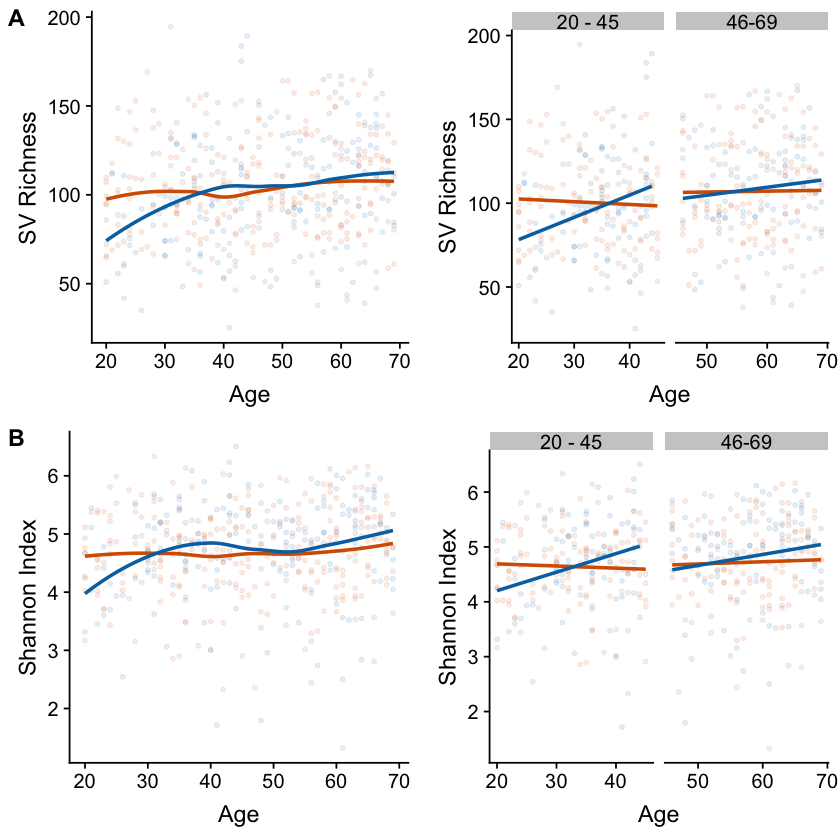

In [54]:
US_richness_6M = ggplot(US_6M, aes(x= Age, y = observed_otus_1250, color = sex)) + 
    geom_point(size = 1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "SV Richness") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_shannon_6M = ggplot(US_6M, aes(x = Age, y = shannon_1250, color = sex)) + 
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_richness_age_group_6M = ggplot(US_6M, aes(x = Age, y = observed_otus_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_shannon_age_group_6M = ggplot(US_6M, aes(x = Age, y = shannon_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~ Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

US_6M_combine_plot = plot_grid(US_richness_6M, US_richness_age_group_6M, 
                               US_shannon_6M, US_shannon_age_group_6M, 
                               ncol = 2, labels = c("A", "", "B", ""))
US_6M_combine_plot
ggsave(filename="./images/US_6M_alpha.png", 
       plot = US_6M_combine_plot, 
       device = "png", dpi = "print")

In [55]:
US_6M %>% group_by(Description, sex) %>%
    summarise(V1=cor(observed_otus_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,-0.04600761
Young,male,0.27325467
Old,female,0.01193844
Old,male,0.10275227


In [56]:
US_6M %>% group_by(Description, sex) %>%
    summarise(V1=cor(shannon_1250, Age, method = "pearson"))

Description,sex,V1
Young,female,-0.04085680
Young,male,0.26830776
Old,female,0.03482091
Old,male,0.15283309


### **ANCOVA of alpha-diversity and sex**

In [57]:
# OTU richness
# With interaction
US_6M_otu_ancova = lm(observed_otus_1250 ~ sex * Age, data = US_6M)
summary(US_6M_otu_ancova)
anova(US_6M_otu_ancova)


Call:
lm(formula = observed_otus_1250 ~ sex * Age, data = US_6M)

Residuals:
    Min      1Q  Median      3Q     Max 
-74.908 -20.310  -1.703  19.895  93.495 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  95.4234     5.8564  16.294   <2e-16 ***
sexmale     -18.2658    10.0306  -1.821   0.0693 .  
Age           0.1833     0.1214   1.510   0.1317    
sexmale:Age   0.3765     0.2059   1.829   0.0681 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 29.57 on 453 degrees of freedom
Multiple R-squared:  0.0292,	Adjusted R-squared:  0.02277 
F-statistic: 4.541 on 3 and 453 DF,  p-value: 0.003779


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,13.2022,13.2022,0.01509981,0.902255609
Age,1,8975.2750,8975.2750,10.26533000,0.001451199
sex:Age,1,2923.6211,2923.6211,3.34384573,0.068114131
Residuals,453,396071.0072,874.3289,NA,NA


In [58]:
# OTU
# Without interaction
US_6M_otu_anova = lm(observed_otus_1250 ~ sex + Age, data = US_6M)
summary(US_6M_otu_anova)
anova(US_6M_otu_anova)


Call:
lm(formula = observed_otus_1250 ~ sex + Age, data = US_6M)

Residuals:
    Min      1Q  Median      3Q     Max 
-76.400 -21.177  -2.005  19.584  95.461 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  89.4012     4.8551  18.414  < 2e-16 ***
sexmale      -0.6799     2.8578  -0.238  0.81207    
Age           0.3141     0.0983   3.196  0.00149 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 29.65 on 454 degrees of freedom
Multiple R-squared:  0.02203,	Adjusted R-squared:  0.01772 
F-statistic: 5.114 on 2 and 454 DF,  p-value: 0.006364


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,13.2022,13.2022,0.01502225,0.902505567
Age,1,8975.2750,8975.2750,10.21260583,0.001492105
Residuals,454,398994.6283,878.8428,NA,NA


In [59]:
# Shannon
# With interaction
US_6M_shannon_ancova = lm(shannon_1250 ~ sex * Age, data = US_6M)
summary(US_6M_shannon_ancova)
anova(US_6M_shannon_ancova)


Call:
lm(formula = shannon_1250 ~ sex * Age, data = US_6M)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3934 -0.4051  0.0848  0.5501  1.7653 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.574214   0.157473  29.048   <2e-16 ***
sexmale     -0.297277   0.269715  -1.102    0.271    
Age          0.002363   0.003264   0.724    0.469    
sexmale:Age  0.008063   0.005536   1.456    0.146    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7951 on 453 degrees of freedom
Multiple R-squared:  0.01561,	Adjusted R-squared:  0.009094 
F-statistic: 2.395 on 3 and 453 DF,  p-value: 0.06767


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,0.7745078,0.7745078,1.225164,0.26893699
Age,1,2.4266363,2.4266363,3.838603,0.05069818
sex:Age,1,1.3410115,1.3410115,2.121294,0.14595647
Residuals,453,286.3714682,0.6321666,NA,NA


In [60]:
# Shannon
# Without interaction
US_6M_shannon_anova = lm(shannon_1250 ~ sex + Age, data = US_6M)
summary(US_6M_shannon_anova)
anova(US_6M_shannon_anova)


Call:
lm(formula = shannon_1250 ~ sex + Age, data = US_6M)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4354 -0.4206  0.0976  0.5448  1.7491 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.445236   0.130375  34.096   <2e-16 ***
sexmale     0.079359   0.076741   1.034    0.302    
Age         0.005165   0.002640   1.957    0.051 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7961 on 454 degrees of freedom
Multiple R-squared:  0.011,	Adjusted R-squared:  0.006647 
F-statistic: 2.526 on 2 and 454 DF,  p-value: 0.08113


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
sex,1,0.7745078,0.7745078,1.222146,0.26952548
Age,1,2.4266363,2.4266363,3.829145,0.05098112
Residuals,454,287.7124797,0.6337279,NA,NA


### Fit separate linear models by each age group

In [61]:
# OTU
# Without interaction
US_6M_otu_group_lm = US_6M %>% group_by(Description) %>%
    do (otu_lm = lm (observed_otus_1250 ~ sex + Age, data=.))

US_6M_otu_group_coef = tidy(US_6M_otu_group_lm, otu_lm)
US_6M_otu_group_coef

US_6M_otu_group_R2 = glance(US_6M_otu_group_lm, otu_lm)
US_6M_otu_group_R2

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),90.8643577,9.3080452,9.7619162,7.002752e-19
Young,sexmale,-3.0731396,4.1044073,-0.7487414,4.548276e-01
Young,Age,0.2883821,0.2715469,1.0619973,2.894228e-01
Old,(Intercept),95.2772836,17.0795281,5.5784494,6.654594e-08
Old,sexmale,1.5825167,4.0171152,0.3939436,6.939799e-01
Old,Age,0.2031560,0.2910037,0.6981216,4.857914e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.007027282,-0.002166910,29.27932,0.7643175,0.4669068,3,-1048.774,2105.548,2119.105,185172.2,216
Old,0.002775858,-0.005711156,30.11019,0.3270712,0.7213601,3,-1146.555,2301.111,2315.000,213056.5,235


In [62]:
# Shannon
# Without interaction
US_6M_shannon_group_lm = US_6M %>% group_by(Description) %>%
    do (shannon_lm = lm (shannon_1250 ~ sex + Age, data=.))

US_6M_shannon_group_coef = tidy(US_6M_shannon_group_lm, shannon_lm)
US_6M_shannon_group_coef

US_6M_shannon_group_R2 = glance(US_6M_shannon_group_lm, shannon_lm)
US_6M_shannon_group_R2

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.392350706,0.245871110,17.8644441,1.957870e-44
Young,sexmale,0.045871886,0.108417521,0.4231040,6.726403e-01
Young,Age,0.007525286,0.007172886,1.0491294,2.952910e-01
Old,(Intercept),4.155801818,0.465188199,8.9335925,1.226380e-16
Old,sexmale,0.105261087,0.109412543,0.9620569,3.370099e-01
Old,Age,0.009750931,0.007925950,1.2302539,2.198321e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.006428298,-0.002771440,0.7734105,0.6987479,0.4983278,3,-252.9661,513.9323,527.4886,129.2034,216
Old,0.010479500,0.002058049,0.8200991,1.2443818,0.2900104,3,-288.9953,585.9905,599.8796,158.0522,235


# Session info
For reproducibility matters

In [63]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS/LAPACK: /Users/jdelacuesta/miniconda3/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  scales_0.5.0    lspline_1.0-0   caret_6.0-80   
 [5] lattice_0.20-35 broom_0.5.0     knitr_1.20      forcats_0.3.0  
 [9] stringr_1.3.1   dplyr_0.7.6     purrr_0.2.5     readr_1.1.1    
[13] tidyr_0.8.1     tibble_1.4.2    tidyverse_1.2.1 cowplot_0.9.4  
[17] ggplot2_3.0.0  

loaded via a namespace (and not attached):
 [1] httr_1.3.1         magic_1.5-8        ddalpha_1.3.4      splines_3.5.1     
 [5] sfsmisc_1.1-2      jsonlite_1.5       foreach_1.4.4      prodlim_2018.04.18
 [9] modelr_0.1.2       assertthat_0.2.0   stats4_3.5.1       DRR_0.0.3         
[13] ce